In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

In [11]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [21]:
from lstm_unet.unet2d import UNet2D

model = UNet2D(in_ch=1, 
               out_ch=32,degree=32).to(device)
out = model(torch.rand(1,1,32,32).to(device))
out.shape

torch.Size([1, 32, 32, 32])

In [23]:
from chnet.unet import UNet
model = UNet2D(in_ch=1, 
               out_ch=32,degree=16).to(device)
summary(model, input_size=(1, 64, 64))

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
#                        in_channels=1, 
#                        out_channels=1, 
#                        init_features=32, 
#                        pretrained=False).double().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           2,320
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
       ConvBlock2d-7           [-1, 16, 64, 64]               0
         MaxPool2d-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,640
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,248
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

(tensor(2162368), tensor(2162368))

In [25]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [29]:
# model = UNet(in_channels=1, 
#              out_channels=1, 
#              init_features=32).double().to(device)
model = UNet2D(in_ch=1, 
               out_ch=1,degree=16).double().to(device)


item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1025, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [38]:
## Process Parameters
dim_x=64
init_steps=1
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*20
n_samples_val = 256
n_samples_prd = 256

init_features=32

In [39]:
args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [40]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 39.7 s, sys: 36.2 s, total: 1min 15s
Wall time: 1min 14s


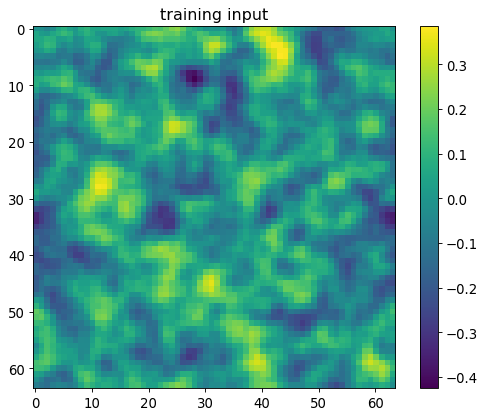

In [41]:
draw_im(x_trn[0], "training input")

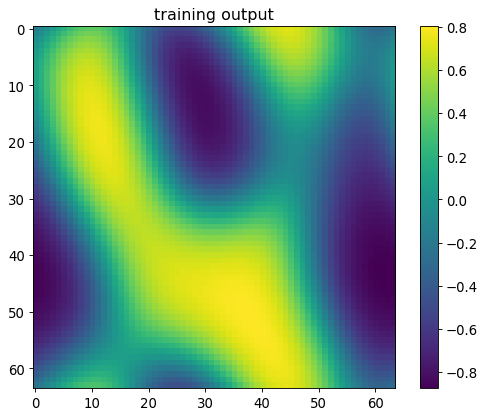

In [42]:
draw_im(y_trn[0], "training output")

In [43]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 4

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 5120
No. of validation steps: 64
No. of prediction steps: 32


In [44]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [45]:
run = 10
run_id = dt_string + "_run_" + "plain"
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)
    
tag = folder+"unet_"
print(tag)

26-06-2020-22-45_run_plain
out/unet/ch_unet_id_26-06-2020-22-45_run_plain/
out/unet/ch_unet_id_26-06-2020-22-45_run_plain/unet_


In [46]:
model = UNet2D(in_ch=1, 
               out_ch=1,degree=16).double().to(device)

In [47]:
num_epochs = 20
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [57]:
# Loss and optimizer
for epoch in range(num_epochs):    
#     torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd = model(x)
        loss = criterion(y_tru, y_prd)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 512 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

Epoch [1/20], Step [1/5120], Training Loss: 6.98827034022, Validation Loss: 6.46943943096
Epoch [1/20], Step [513/5120], Training Loss: 6.91444909418, Validation Loss: 6.53338010174
Epoch [1/20], Step [1025/5120], Training Loss: 6.91848847781, Validation Loss: 7.10916930526
Epoch [1/20], Step [1537/5120], Training Loss: 7.27930241220, Validation Loss: 5.89887601628
Epoch [1/20], Step [2049/5120], Training Loss: 7.03038295536, Validation Loss: 7.61849708128
Epoch [1/20], Step [2561/5120], Training Loss: 7.42917978928, Validation Loss: 7.14686331441
Epoch [1/20], Step [3073/5120], Training Loss: 7.06031079689, Validation Loss: 8.22441985701
Epoch [1/20], Step [3585/5120], Training Loss: 7.08452687302, Validation Loss: 6.66651298496
Epoch [1/20], Step [4097/5120], Training Loss: 6.89921564802, Validation Loss: 5.65243663383
Epoch [1/20], Step [4609/5120], Training Loss: 6.83558396925, Validation Loss: 7.63440246656



Epoch [2/20], Step [1/5120], Training Loss: 6.84857736485, Validation Loss: 6.10044996713
Epoch [2/20], Step [513/5120], Training Loss: 6.74406413519, Validation Loss: 6.26217620632
Epoch [2/20], Step [1025/5120], Training Loss: 7.00531533719, Validation Loss: 7.64978024133
Epoch [2/20], Step [1537/5120], Training Loss: 7.14903443389, Validation Loss: 9.33487734253
Epoch [2/20], Step [2049/5120], Training Loss: 6.62929167596, Validation Loss: 5.67443489474
Epoch [2/20], Step [2561/5120], Training Loss: 7.11962982010, Validation Loss: 6.01166025707
Epoch [2/20], Step [3073/5120], Training Loss: 6.88567553968, Validation Loss: 6.27938138352
Epoch [2/20], Step [3585/5120], Training Loss: 6.82036037449, Validation Loss: 6.43951356147
Epoch [2/20], Step [4097/5120], Training Loss: 6.94946794858, Validation Loss: 6.43927175152
Epoch [2/20], Step [4609/5120], Training Loss: 6.88395338989, Validation Loss: 8.24986949476



Epoch [3/20], Step [1/5120], Training Loss: 6.85797666910, Validation Loss: 6.51743326160
Epoch [3/20], Step [513/5120], Training Loss: 6.72249335243, Validation Loss: 7.96078411080
Epoch [3/20], Step [1025/5120], Training Loss: 6.77192601615, Validation Loss: 6.99009600940
Epoch [3/20], Step [1537/5120], Training Loss: 6.88836052655, Validation Loss: 6.01472090068
Epoch [3/20], Step [2049/5120], Training Loss: 6.63945113264, Validation Loss: 6.76988895870
Epoch [3/20], Step [2561/5120], Training Loss: 6.18475689079, Validation Loss: 5.66068505974
Epoch [3/20], Step [3073/5120], Training Loss: 6.85597058243, Validation Loss: 5.48657467099
Epoch [3/20], Step [3585/5120], Training Loss: 6.60371542252, Validation Loss: 5.86189465154
Epoch [3/20], Step [4097/5120], Training Loss: 6.57931164070, Validation Loss: 7.50470969510
Epoch [3/20], Step [4609/5120], Training Loss: 6.14695452897, Validation Loss: 4.65680720112



Epoch [4/20], Step [1/5120], Training Loss: 6.61459204763, Validation Loss: 6.66636581728
Epoch [4/20], Step [513/5120], Training Loss: 6.40902967592, Validation Loss: 5.03800329323
Epoch [4/20], Step [1025/5120], Training Loss: 6.14642504297, Validation Loss: 6.13782395801
Epoch [4/20], Step [1537/5120], Training Loss: 6.64356379089, Validation Loss: 7.68138276142
Epoch [4/20], Step [2049/5120], Training Loss: 6.69015807828, Validation Loss: 5.26190346258
Epoch [4/20], Step [2561/5120], Training Loss: 6.24811571308, Validation Loss: 8.72572139107
Epoch [4/20], Step [3073/5120], Training Loss: 6.02354139879, Validation Loss: 5.43008386482
Epoch [4/20], Step [3585/5120], Training Loss: 6.28669324001, Validation Loss: 7.55111278089
Epoch [4/20], Step [4097/5120], Training Loss: 6.34812825889, Validation Loss: 7.37877087404
Epoch [4/20], Step [4609/5120], Training Loss: 5.91648314234, Validation Loss: 5.29753087540



Epoch [5/20], Step [1/5120], Training Loss: 6.45206647303, Validation Loss: 6.40775464522
Epoch [5/20], Step [513/5120], Training Loss: 6.46218494540, Validation Loss: 5.59775927185
Epoch [5/20], Step [1025/5120], Training Loss: 6.20453183625, Validation Loss: 5.32280663586
Epoch [5/20], Step [1537/5120], Training Loss: 5.94696328192, Validation Loss: 8.49988772411
Epoch [5/20], Step [2049/5120], Training Loss: 6.08036046024, Validation Loss: 5.16837764462
Epoch [5/20], Step [2561/5120], Training Loss: 6.33000883399, Validation Loss: 6.21787112873
Epoch [5/20], Step [3073/5120], Training Loss: 6.07445246494, Validation Loss: 4.91387620958
Epoch [5/20], Step [3585/5120], Training Loss: 6.38916944623, Validation Loss: 8.01908398146
Epoch [5/20], Step [4097/5120], Training Loss: 6.27571055725, Validation Loss: 6.42078828107
Epoch [5/20], Step [4609/5120], Training Loss: 6.04299365838, Validation Loss: 6.37608437800



Epoch [6/20], Step [1/5120], Training Loss: 5.87666398840, Validation Loss: 6.00090060068
Epoch [6/20], Step [513/5120], Training Loss: 6.06192586781, Validation Loss: 6.63664837653
Epoch [6/20], Step [1025/5120], Training Loss: 6.05486805583, Validation Loss: 6.33448732129
Epoch [6/20], Step [1537/5120], Training Loss: 6.16769324710, Validation Loss: 6.74489232490
Epoch [6/20], Step [2049/5120], Training Loss: 6.35801600625, Validation Loss: 8.34036483476
Epoch [6/20], Step [2561/5120], Training Loss: 6.09034592787, Validation Loss: 5.06065662495
Epoch [6/20], Step [3073/5120], Training Loss: 6.35671552277, Validation Loss: 5.68777109394
Epoch [6/20], Step [3585/5120], Training Loss: 6.11588218591, Validation Loss: 5.91133908037
Epoch [6/20], Step [4097/5120], Training Loss: 5.81890609280, Validation Loss: 5.39082229341
Epoch [6/20], Step [4609/5120], Training Loss: 5.72921814397, Validation Loss: 6.39600350117



Epoch [7/20], Step [1/5120], Training Loss: 5.56119993151, Validation Loss: 5.57389054075
Epoch [7/20], Step [513/5120], Training Loss: 5.95039023833, Validation Loss: 5.79227555164
Epoch [7/20], Step [1025/5120], Training Loss: 5.66825020878, Validation Loss: 4.58182458442
Epoch [7/20], Step [1537/5120], Training Loss: 5.83283798702, Validation Loss: 4.89667937193
Epoch [7/20], Step [2049/5120], Training Loss: 6.19340467016, Validation Loss: 5.52353887483
Epoch [7/20], Step [2561/5120], Training Loss: 5.41970259338, Validation Loss: 5.04284857554
Epoch [7/20], Step [3073/5120], Training Loss: 6.13129384411, Validation Loss: 4.86913942814
Epoch [7/20], Step [3585/5120], Training Loss: 6.34656177215, Validation Loss: 5.52565342060
Epoch [7/20], Step [4097/5120], Training Loss: 5.94511599332, Validation Loss: 6.16254181601
Epoch [7/20], Step [4609/5120], Training Loss: 5.38105055726, Validation Loss: 5.50406665741



Epoch [8/20], Step [1/5120], Training Loss: 5.65321998706, Validation Loss: 4.83741887102
Epoch [8/20], Step [513/5120], Training Loss: 5.55864704795, Validation Loss: 4.72878755595
Epoch [8/20], Step [1025/5120], Training Loss: 5.62545045396, Validation Loss: 4.88785963045
Epoch [8/20], Step [1537/5120], Training Loss: 5.62014762252, Validation Loss: 6.15508399621
Epoch [8/20], Step [2049/5120], Training Loss: 5.50792604681, Validation Loss: 5.27981370847
Epoch [8/20], Step [2561/5120], Training Loss: 5.91409156743, Validation Loss: 7.26384217434
Epoch [8/20], Step [3073/5120], Training Loss: 5.80264662114, Validation Loss: 4.67315700724
Epoch [8/20], Step [3585/5120], Training Loss: 5.89146694136, Validation Loss: 5.64788011675
Epoch [8/20], Step [4097/5120], Training Loss: 5.50365175114, Validation Loss: 4.89417174926
Epoch [8/20], Step [4609/5120], Training Loss: 6.09789229760, Validation Loss: 5.27749871353



Epoch [9/20], Step [1/5120], Training Loss: 5.34188322125, Validation Loss: 4.19438956378
Epoch [9/20], Step [513/5120], Training Loss: 5.67841832270, Validation Loss: 8.00704467825
Epoch [9/20], Step [1025/5120], Training Loss: 5.62737894661, Validation Loss: 5.16458800123
Epoch [9/20], Step [1537/5120], Training Loss: 5.21270953587, Validation Loss: 4.34326685730
Epoch [9/20], Step [2049/5120], Training Loss: 5.40378559365, Validation Loss: 4.90211386022
Epoch [9/20], Step [2561/5120], Training Loss: 5.14076983565, Validation Loss: 5.37468858043
Epoch [9/20], Step [3073/5120], Training Loss: 5.71814744887, Validation Loss: 12.40687130831
Epoch [9/20], Step [3585/5120], Training Loss: 5.51999357869, Validation Loss: 4.72143727764
Epoch [9/20], Step [4097/5120], Training Loss: 5.54499844366, Validation Loss: 4.53155462042
Epoch [9/20], Step [4609/5120], Training Loss: 5.75279718696, Validation Loss: 5.46430229361



Epoch [10/20], Step [1/5120], Training Loss: 5.41370574388, Validation Loss: 4.45495172766
Epoch [10/20], Step [513/5120], Training Loss: 5.08737666825, Validation Loss: 4.69684806669
Epoch [10/20], Step [1025/5120], Training Loss: 5.01739065718, Validation Loss: 4.99078392780
Epoch [10/20], Step [1537/5120], Training Loss: 5.40773968560, Validation Loss: 4.66065117785
Epoch [10/20], Step [2049/5120], Training Loss: 5.32117337603, Validation Loss: 6.15752609865
Epoch [10/20], Step [2561/5120], Training Loss: 5.12817598663, Validation Loss: 4.73200143061
Epoch [10/20], Step [3073/5120], Training Loss: 5.51314037976, Validation Loss: 4.32366421353
Epoch [10/20], Step [3585/5120], Training Loss: 5.90325425862, Validation Loss: 7.23710940028
Epoch [10/20], Step [4097/5120], Training Loss: 4.96128815415, Validation Loss: 7.30328712452
Epoch [10/20], Step [4609/5120], Training Loss: 5.15250862570, Validation Loss: 4.60368069639



Epoch [11/20], Step [1/5120], Training Loss: 5.26778416340, Validation Loss: 4.41084263508
Epoch [11/20], Step [513/5120], Training Loss: 5.70143093222, Validation Loss: 5.33605173863
Epoch [11/20], Step [1025/5120], Training Loss: 5.24130391451, Validation Loss: 4.80836174336
Epoch [11/20], Step [1537/5120], Training Loss: 5.17729819406, Validation Loss: 4.98718941390
Epoch [11/20], Step [2049/5120], Training Loss: 5.00443885182, Validation Loss: 5.48834384972
Epoch [11/20], Step [2561/5120], Training Loss: 4.83124056049, Validation Loss: 4.21253168726
Epoch [11/20], Step [3073/5120], Training Loss: 5.13249522874, Validation Loss: 4.12781574767
Epoch [11/20], Step [3585/5120], Training Loss: 5.22965451153, Validation Loss: 8.08438828434
Epoch [11/20], Step [4097/5120], Training Loss: 5.35463677985, Validation Loss: 4.84969978797
Epoch [11/20], Step [4609/5120], Training Loss: 5.14325043828, Validation Loss: 5.26398317493



Epoch [12/20], Step [1/5120], Training Loss: 5.09313091763, Validation Loss: 5.84908764004
Epoch [12/20], Step [513/5120], Training Loss: 4.94232812427, Validation Loss: 4.01403622807
Epoch [12/20], Step [1025/5120], Training Loss: 4.81506617075, Validation Loss: 4.70801733137
Epoch [12/20], Step [1537/5120], Training Loss: 4.85611051120, Validation Loss: 4.62757357280
Epoch [12/20], Step [2049/5120], Training Loss: 5.02023884794, Validation Loss: 6.61937473198
Epoch [12/20], Step [2561/5120], Training Loss: 5.42843243362, Validation Loss: 4.62086944033
Epoch [12/20], Step [3073/5120], Training Loss: 5.00459212413, Validation Loss: 4.94234999261
Epoch [12/20], Step [3585/5120], Training Loss: 4.76081076888, Validation Loss: 4.00009626366
Epoch [12/20], Step [4097/5120], Training Loss: 4.98034020299, Validation Loss: 8.08276807526
Epoch [12/20], Step [4609/5120], Training Loss: 4.73116259074, Validation Loss: 4.62847223706



Epoch [13/20], Step [1/5120], Training Loss: 4.84346176040, Validation Loss: 3.84735389181
Epoch [13/20], Step [513/5120], Training Loss: 4.89620639881, Validation Loss: 4.65239648555
Epoch [13/20], Step [1025/5120], Training Loss: 5.09752795866, Validation Loss: 4.47840121713
Epoch [13/20], Step [1537/5120], Training Loss: 4.84858171424, Validation Loss: 4.96991655501
Epoch [13/20], Step [2049/5120], Training Loss: 4.75799469093, Validation Loss: 4.09584763745
Epoch [13/20], Step [2561/5120], Training Loss: 5.04296295052, Validation Loss: 4.86077959272
Epoch [13/20], Step [3073/5120], Training Loss: 5.09629749155, Validation Loss: 5.42950050735
Epoch [13/20], Step [3585/5120], Training Loss: 4.83150476680, Validation Loss: 4.98038521085
Epoch [13/20], Step [4097/5120], Training Loss: 4.90338740206, Validation Loss: 4.15139285725
Epoch [13/20], Step [4609/5120], Training Loss: 5.00607372892, Validation Loss: 5.21314941129



Epoch [14/20], Step [1/5120], Training Loss: 5.25895733099, Validation Loss: 6.22656308071
Epoch [14/20], Step [513/5120], Training Loss: 4.94237174886, Validation Loss: 4.39750994251
Epoch [14/20], Step [1025/5120], Training Loss: 5.06158078548, Validation Loss: 3.88385502619
Epoch [14/20], Step [1537/5120], Training Loss: 4.83712782178, Validation Loss: 6.43854361878
Epoch [14/20], Step [2049/5120], Training Loss: 4.95010354812, Validation Loss: 4.04204727079
Epoch [14/20], Step [2561/5120], Training Loss: 4.74128783832, Validation Loss: 4.38709584675
Epoch [14/20], Step [3073/5120], Training Loss: 5.05867289576, Validation Loss: 4.98129770988
Epoch [14/20], Step [3585/5120], Training Loss: 4.62865895453, Validation Loss: 4.41030991391
Epoch [14/20], Step [4097/5120], Training Loss: 4.68117076792, Validation Loss: 5.34724618633
Epoch [14/20], Step [4609/5120], Training Loss: 5.02679990993, Validation Loss: 4.50887323772



Epoch [15/20], Step [1/5120], Training Loss: 4.54153496838, Validation Loss: 4.15469563070
Epoch [15/20], Step [513/5120], Training Loss: 4.79619350575, Validation Loss: 5.28912549829
Epoch [15/20], Step [1025/5120], Training Loss: 4.64824796525, Validation Loss: 4.26874198333
Epoch [15/20], Step [1537/5120], Training Loss: 4.54225889510, Validation Loss: 4.12554159180
Epoch [15/20], Step [2049/5120], Training Loss: 4.57355480015, Validation Loss: 9.81366344623
Epoch [15/20], Step [2561/5120], Training Loss: 4.50757542614, Validation Loss: 4.37528463780
Epoch [15/20], Step [3073/5120], Training Loss: 4.64248008062, Validation Loss: 4.45895084337
Epoch [15/20], Step [3585/5120], Training Loss: 4.61002938477, Validation Loss: 4.34869453723
Epoch [15/20], Step [4097/5120], Training Loss: 5.63718225026, Validation Loss: 4.87799326972
Epoch [15/20], Step [4609/5120], Training Loss: 4.82317759335, Validation Loss: 6.87568585988



Epoch [16/20], Step [1/5120], Training Loss: 5.75822449602, Validation Loss: 4.33755416555
Epoch [16/20], Step [513/5120], Training Loss: 4.71555829840, Validation Loss: 4.24621600977
Epoch [16/20], Step [1025/5120], Training Loss: 4.69096878548, Validation Loss: 4.15025970082
Epoch [16/20], Step [1537/5120], Training Loss: 4.58540657353, Validation Loss: 3.85982725694
Epoch [16/20], Step [2049/5120], Training Loss: 4.50156792183, Validation Loss: 5.37145356911
Epoch [16/20], Step [2561/5120], Training Loss: 4.57696845501, Validation Loss: 5.03009859485
Epoch [16/20], Step [3073/5120], Training Loss: 4.45059989735, Validation Loss: 6.28707808754
Epoch [16/20], Step [3585/5120], Training Loss: 4.35682419049, Validation Loss: 6.58524895030
Epoch [16/20], Step [4097/5120], Training Loss: 4.43355678917, Validation Loss: 3.73997836003
Epoch [16/20], Step [4609/5120], Training Loss: 4.33919351992, Validation Loss: 3.97404884223



Epoch [17/20], Step [1/5120], Training Loss: 4.70700836802, Validation Loss: 3.67759790331
Epoch [17/20], Step [513/5120], Training Loss: 4.62807560672, Validation Loss: 3.61874634127
Epoch [17/20], Step [1025/5120], Training Loss: 4.65170883218, Validation Loss: 4.26481577464
Epoch [17/20], Step [1537/5120], Training Loss: 4.60500972319, Validation Loss: 4.12647392372
Epoch [17/20], Step [2049/5120], Training Loss: 4.32092092803, Validation Loss: 4.03529616319
Epoch [17/20], Step [2561/5120], Training Loss: 4.67579245668, Validation Loss: 3.61230825476
Epoch [17/20], Step [3073/5120], Training Loss: 4.36161204136, Validation Loss: 3.70983335940
Epoch [17/20], Step [3585/5120], Training Loss: 5.46659883059, Validation Loss: 3.80142048994
Epoch [17/20], Step [4097/5120], Training Loss: 4.47713244790, Validation Loss: 4.69950842899
Epoch [17/20], Step [4609/5120], Training Loss: 4.47812568445, Validation Loss: 3.46513853146



Epoch [18/20], Step [1/5120], Training Loss: 4.51699651458, Validation Loss: 7.71202487790
Epoch [18/20], Step [513/5120], Training Loss: 4.59551650728, Validation Loss: 8.34892015883
Epoch [18/20], Step [1025/5120], Training Loss: 4.38574179318, Validation Loss: 6.67300203783
Epoch [18/20], Step [1537/5120], Training Loss: 4.27979507923, Validation Loss: 6.66624612959
Epoch [18/20], Step [2049/5120], Training Loss: 4.82298726425, Validation Loss: 5.56520870248
Epoch [18/20], Step [2561/5120], Training Loss: 4.55256239768, Validation Loss: 5.42630968040
Epoch [18/20], Step [3073/5120], Training Loss: 4.23058244373, Validation Loss: 4.75477403556
Epoch [18/20], Step [3585/5120], Training Loss: 4.34234892911, Validation Loss: 4.04485213099
Epoch [18/20], Step [4097/5120], Training Loss: 4.32944354921, Validation Loss: 4.39992058184
Epoch [18/20], Step [4609/5120], Training Loss: 4.90419683973, Validation Loss: 5.13582065468



Epoch [19/20], Step [1/5120], Training Loss: 4.72105095591, Validation Loss: 5.55265317750
Epoch [19/20], Step [513/5120], Training Loss: 4.32877192208, Validation Loss: 3.92226229613
Epoch [19/20], Step [1025/5120], Training Loss: 4.60683005502, Validation Loss: 4.64937085722
Epoch [19/20], Step [1537/5120], Training Loss: 4.36223018164, Validation Loss: 3.86999937655
Epoch [19/20], Step [2049/5120], Training Loss: 4.23460990279, Validation Loss: 3.91293841815
Epoch [19/20], Step [2561/5120], Training Loss: 4.34427478029, Validation Loss: 3.67277922458
Epoch [19/20], Step [3073/5120], Training Loss: 4.30370709473, Validation Loss: 3.93654599274
Epoch [19/20], Step [3585/5120], Training Loss: 4.43844306607, Validation Loss: 3.91119937748
Epoch [19/20], Step [4097/5120], Training Loss: 4.17054499821, Validation Loss: 5.77032289496
Epoch [19/20], Step [4609/5120], Training Loss: 4.43392838892, Validation Loss: 4.59495567205



Epoch [20/20], Step [1/5120], Training Loss: 4.26031661567, Validation Loss: 3.76857434035
Epoch [20/20], Step [513/5120], Training Loss: 4.70243698913, Validation Loss: 6.62247037975
Epoch [20/20], Step [1025/5120], Training Loss: 4.40676240232, Validation Loss: 3.96554961346
Epoch [20/20], Step [1537/5120], Training Loss: 4.47689142878, Validation Loss: 8.14699291366
Epoch [20/20], Step [2049/5120], Training Loss: 4.01583079817, Validation Loss: 4.68017178170
Epoch [20/20], Step [2561/5120], Training Loss: 4.17765222671, Validation Loss: 5.31253576863
Epoch [20/20], Step [3073/5120], Training Loss: 4.34148582389, Validation Loss: 4.10016213571
Epoch [20/20], Step [3585/5120], Training Loss: 4.20411852557, Validation Loss: 7.14054091709
Epoch [20/20], Step [4097/5120], Training Loss: 4.24855547014, Validation Loss: 3.69253122866
Epoch [20/20], Step [4609/5120], Training Loss: 4.22839570183, Validation Loss: 5.41209565620



In [71]:
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

In [58]:
prd_losses = []
for item_prd in trn_loader:
    model.eval()
    x1 = item_prd['x'].to(device)
    y1 = item_prd['y'].to(device)
    # Forward pass
    y2 = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

4.7817283228082115 1.1507158331424312


In [59]:
prd_losses = []
for item_prd in val_loader:
    model.eval()
    x1 = item_prd['x'].to(device)
    y1 = item_prd['y'].to(device)
    # Forward pass
    y2 = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

5.6381085390169075 1.2291170244896317


In [60]:
print(prd_losses)

[6.170325169694467, 4.611723559301132, 4.529663895314274, 7.616023726047039, 6.3270588822454314, 4.5134792944302085, 9.757707650936355, 6.501970826698938, 5.3385318798685315, 4.34974577605204, 5.394941941849268, 9.01766276494145, 4.33102060488013, 4.683780052908197, 4.81951942008626, 5.231335458432109, 5.831412294728125, 4.485527013094833, 5.138522407343407, 5.190505080352153, 5.218855750873663, 5.207786554013761, 5.080163595570918, 4.635652409051067, 5.368483637849737, 4.9079147691151475, 6.988130590413759, 4.415669652076606, 6.066902709271327, 6.049107005502744, 4.610781854331502, 5.2776398723069455, 4.6255562235528425, 7.05301288287775, 5.873580890102438, 5.844990317039657, 4.344817955377285, 5.060671266131511, 6.809456573694755, 4.771613613732213, 4.508569129960118, 6.094725540311915, 6.3095546701862695, 4.340485306796829, 7.499334943137558, 5.9498338143168, 6.435099085359658, 5.707385290070879, 4.599884409264511, 4.820624551951783, 4.531399769812288, 6.523535801247952, 7.836745325

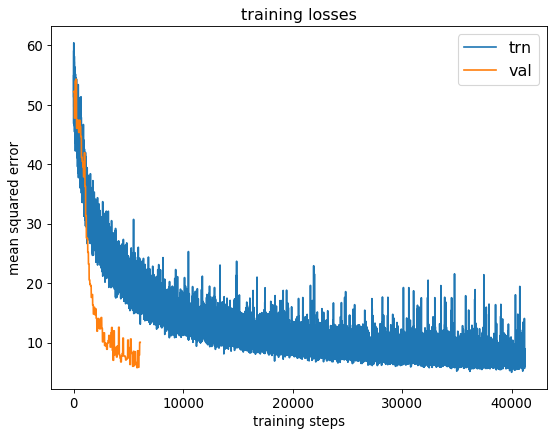

In [52]:
plt.plot(trn_losses)
plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

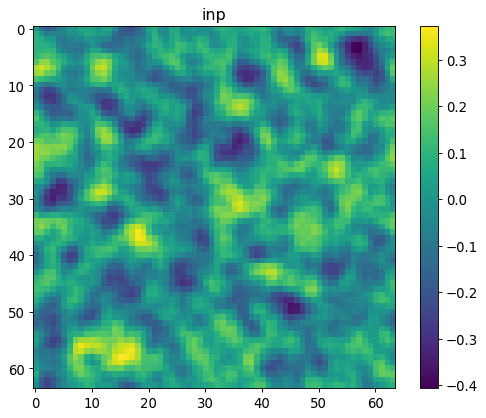

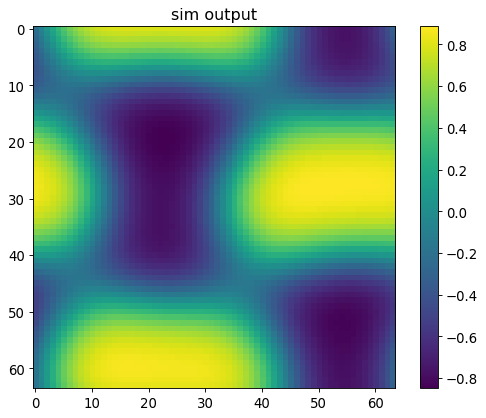

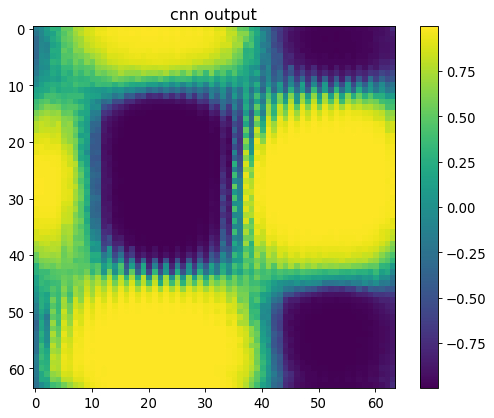

tensor(0.1933, device='cuda:0', dtype=torch.float64)


In [61]:
ix = 12

item_prd = val_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

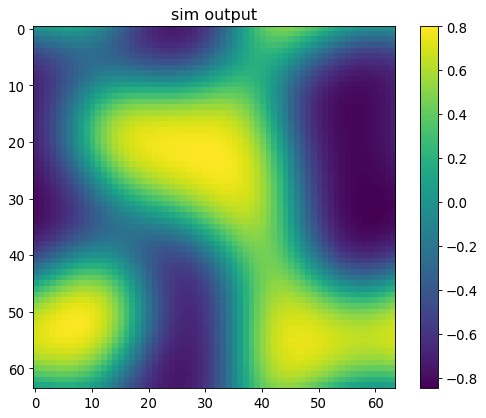

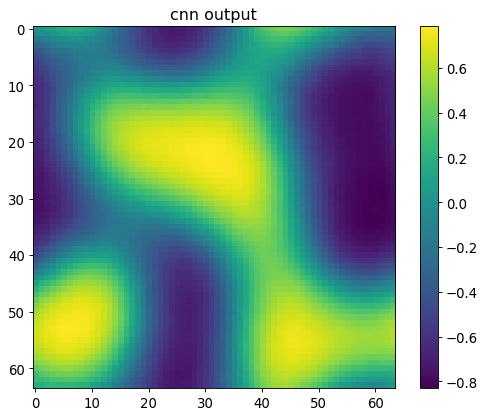

tensor(0.0030, device='cuda:0', dtype=torch.float64)


In [62]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

# draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

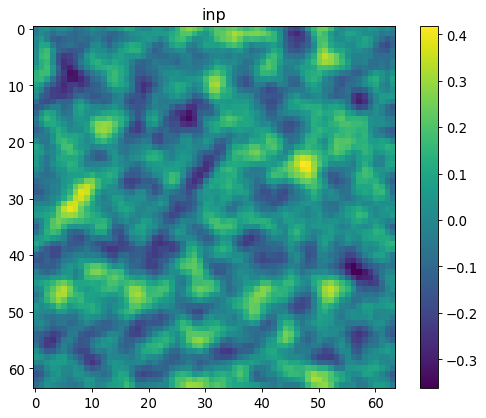

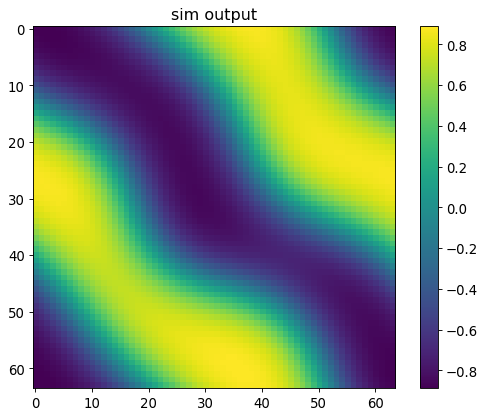

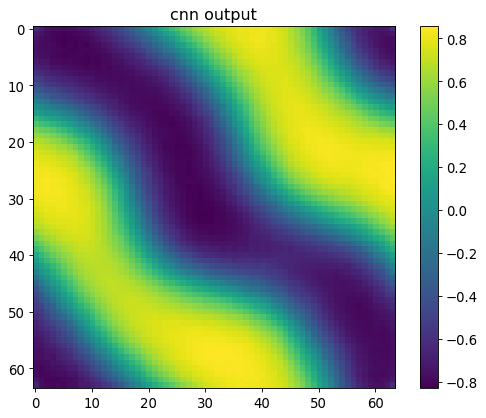

tensor(0.0028, device='cuda:0', dtype=torch.float64)


In [63]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

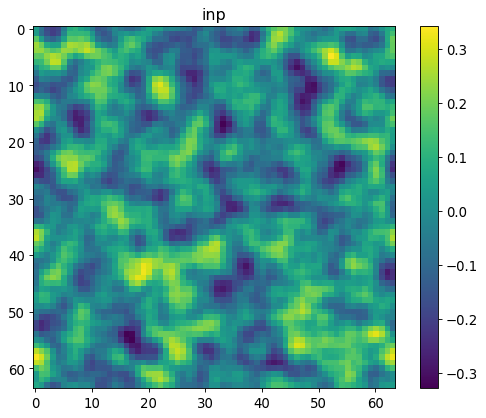

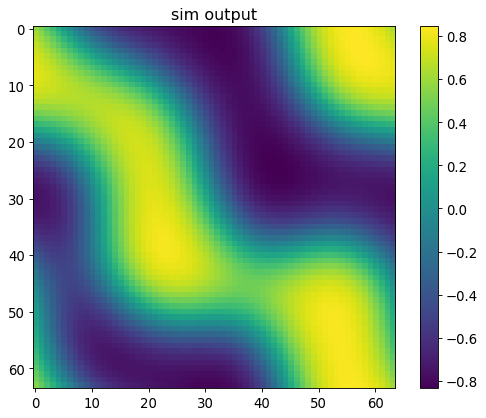

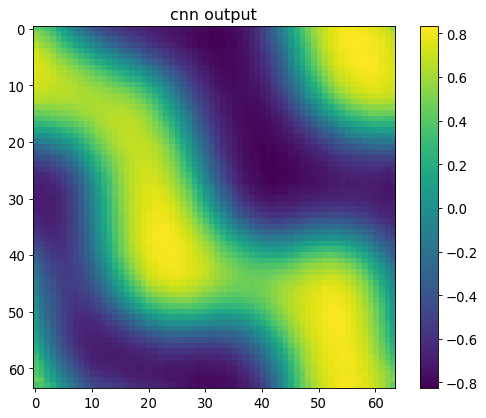

tensor(0.0017, device='cuda:0', dtype=torch.float64)


In [64]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)